In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.animation as animation

from torch.utils.data import Dataset
import binvox
import os
import json
import trimesh
import skimage
import random
from mesh_to_sdf import mesh_to_voxels, sample_sdf_near_surface, scale_to_unit_sphere
import mesh_to_sdf
import pyrender
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import io
from deep_sdf import utils, metrics


import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

In [5]:
plane_gt = "/mnt/hdd/ShapeNetCore.v2/02691156/12c82319147385e7ef0e1705c5c9e361/models/model_normalized.obj"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=2020.ply"
plane_recon = "examples/plane_ours/TensorBoard/ReconstructionsTrain/02691156_12c82319147385e7ef0e1705c5c9e361/train_mesh_epoch=120.ply"

In [6]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

In [7]:
metrics.compute_metric(gt_mesh, recon_mesh)

0.07700319746289094

In [15]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


AttributeError: 'Scene' object has no attribute 'area_faces'

In [2]:
metrics.compute_metric(trimesh.load_mesh(plane_gt), trimesh.load_mesh(plane_recon))


NameError: name 'plane_gt' is not defined

In [4]:
for epoch in [200, 400, 600, 800, 1000]:
    print("EPOCH: ", epoch)
    get_recon_path = lambda class_id, shape_id: f"/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain/{class_id}_{shape_id}/epoch={epoch}.ply"
    get_gt_path = lambda class_id, shape_id: f"/mnt/hdd/ShapeNetCore.v2/{class_id}/{shape_id}/models/model_normalized.obj"

    reconstr_dirs = os.listdir("/home/shared/deepsdfcomp/searches/ffe_100_shapes/exp_0011_CodeLength=60_encoding_features=23_encoding_sigma=0.783/TensorBoard/ReconstructionsTrain")
    shapes = [dir_name.split("_") for dir_name in reconstr_dirs]

    cds = []
    for (class_id, shape_id) in shapes:
        gt_path = get_gt_path(class_id, shape_id)
        gt_mesh = utils.as_mesh(trimesh.load_mesh(gt_path))
        recon_path = get_recon_path(class_id, shape_id)
        recon_mesh = utils.as_mesh(trimesh.load_mesh(recon_path))
        cd = metrics.compute_metric(gt_mesh, recon_mesh, num_mesh_samples=30000)
        print(f"Shape {shape_id} from class {class_id} with CD={cd:.3f}")
        cds.append(cd)
    print(f"Avg CD={sum(cds)/len(cds):.4f}")

EPOCH:  200


TypeError: unsupported format string passed to tuple.__format__

In [5]:
gt_mesh = utils.as_mesh(trimesh.load_mesh(plane_gt))
recon_mesh = utils.as_mesh(trimesh.load_mesh(plane_recon))

[['02691156', '122963149f6a04272620819ddac40644'],
 ['02691156', '124062ccaeae95085e9e2656aff7dd5b'],
 ['02691156', '1628b65a9f3cd7c05e9e2656aff7dd5b'],
 ['02691156', '144070f63941362bd1810447902e2904'],
 ['02691156', '10cfc2090a2ade124c3a35cee92bb95b']]

In [3]:
metrics.compute_metric(gt_mesh, gt_mesh, num_mesh_samples=30000)

5.876217082101655e-06

In [5]:
cd, all_dists = metrics.compute_metric(recon_mesh, recon_mesh, num_mesh_samples=30000)

In [35]:
np.percentile(all_dists, [0, 10, 90])

array([1.71868840e-05, 1.33383005e-03, 6.24397503e-03])

TypeError: text() missing 2 required positional arguments: 'y' and 's'

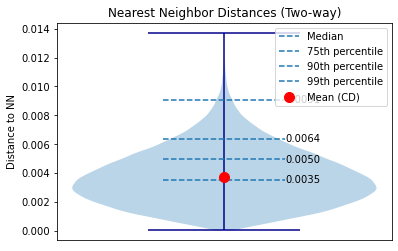

In [17]:
fig, ax = plt.subplots(1, 1)
ax.set_ylabel("Distance to NN")
ax.set_title("Nearest Neighbor Distances (Two-way)")
ax.set_xticks([])
#ax.set_xlim(0.5, 1.5)
data = all_dists

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

vplot = ax.violinplot(data, showmeans=False, showextrema=True)
vplot["cmaxes"].set_edgecolor("darkblue")
vplot["cmins"].set_edgecolor("darkblue")
vplot["cbars"].set_edgecolor("darkblue")

percentile_keys = [50, 75, 90, 99]
percentiles = np.percentile(data, percentile_keys)
percentiles = {k: p for k, p in zip(percentile_keys, percentiles)}

for k, p in percentiles.items():
    k = f"{k}th percentile" if k!=50 else "Median"
    ax.hlines([p], xmin=[0.9], xmax=[1.1], linestyles="--", label=k)
    ax.annotate(f"{p:.4f}", xy=[1.1, p], va="center")

ax.scatter(1, np.mean(data), marker="o", color="red", s=100, zorder=999, label="Mean (CD)")
ax.legend(loc="best")

for vp in vplot["bodies"]:
    vp.set_facecolor("cornflowerblue")
    vp.set_zorder(2)
    vp.set_alpha(1)
    vp.set_linewidth(1)

# Reduce the length of horizontal lines 
# (from: https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py)
factor_x, factor_y = 0.3, 1 # factor to reduce the lengths
for vp_part in ("cbars", "cmaxes", "cmins"):
    vp = vplot[vp_part]
    if vp_part in ("cmaxes", "cmins"):
        lines = vp.get_segments()
        new_lines = []
        for line in lines:
            center = line.mean(axis=0)
            line = (line - center) * np.array([factor_x, factor_y]) + center
            new_lines.append(line)
        vp.set_segments(new_lines)
    vp.set_edgecolor("black")

In [62]:
vp

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f7a57cbee20>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f7a57cbecd0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f7a57c484c0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f7a57c48880>}